In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

In [3]:
trip_files = "/Users/woals/data-engineering/01-spark/data/trips/*"
zone_file = "/Users/woals/data-engineering/01-spark/data/taxi+_zone_lookup.csv"

In [4]:
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header=True)

In [5]:
trips_df = spark.read.csv(f"file:///{trip_files}", inferSchema=True, header=True)

In [6]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-

In [7]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [8]:
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON 
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [9]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [10]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2020-12-31|         23|
| 2020-12-31|         21|
| 2020-12-31|         23|
| 2020-12-31|         18|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2020-12-31|         23|
| 2020-12-31|         13|
| 2020-12-31|         23|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
+-----------+-----------+
only showing top 20 rows



In [11]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_date < '2020-12-31'").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|         17|
| 2009-01-01|         17|
| 2009-01-01|         18|
| 2009-01-01|          1|
| 2009-01-01|          1|
| 2009-01-01|          2|
| 2009-01-01|          2|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [12]:
comb_df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          30904308|
|   mean|19.696304829899013|
| stddev|179.19426093049088|
|    min|            -951.0|
|    max|         818286.74|
+-------+------------------+



In [13]:
comb_df.select("trip_distance").describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|          30904308|
|   mean|6.9226886743426945|
| stddev| 698.3799511182619|
|    min|               0.0|
|    max|         351613.36|
+-------+------------------+



In [14]:
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          29425613|
|   mean|1.4274682399989425|
| stddev|1.0333753094086433|
|    min|               0.0|
|    max|             112.0|
+-------+------------------+



In [15]:
query = """
SELECT
     DATE_TRUNC('MM', c.pickup_date) AS month,
     COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2098-09-01 00:00:00|      1|
|2070-08-01 00:00:00|      1|
|2029-05-01 00:00:00|      1|
|2028-12-01 00:00:00|      1|
|2022-03-01 00:00:00|      3|
|2022-02-01 00:00:00|     10|
|2022-01-01 00:00:00|     36|
|2021-12-01 00:00:00|3214295|
|2021-11-01 00:00:00|3472897|
|2021-10-01 00:00:00|3463485|
|2021-09-01 00:00:00|2963778|
|2021-08-01 00:00:00|2788300|
|2021-07-01 00:00:00|2822113|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371689|
|2021-01-01 00:00:00|1369753|
|2020-12-01 00:00:00|     16|
+-------------------+-------+
only showing top 20 rows



In [29]:
# Data Clearning
query = """
SELECT
    *
FROM 
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-12-01'
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [30]:
cleaned_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|      payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+
|  count|          24723561|          24723561|          24723561|          24723561|          24723561|          24723561|          24723561|           24723561|          24723561|          24723561|            24723561|            24723561|
|   mean|1.6750174459091876|

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [32]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()

<Axes: xlabel='pickup_date', ylabel='trips'>

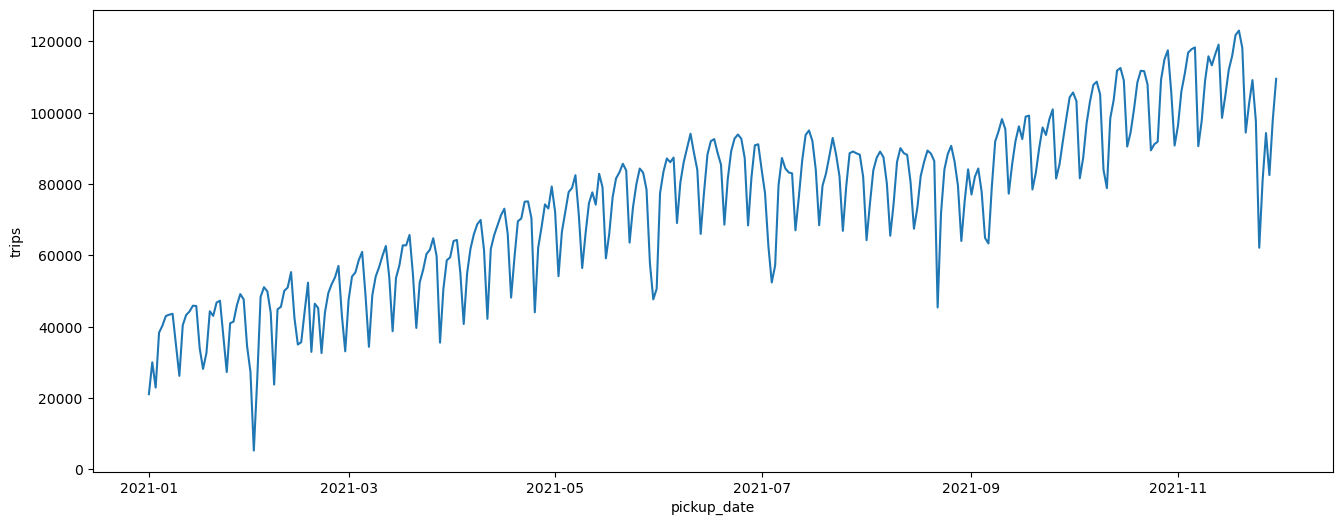

In [33]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

In [34]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [35]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [36]:
data.sort_values(by="sort_dow", inplace=True)

<Axes: xlabel='day_of_week', ylabel='trips'>

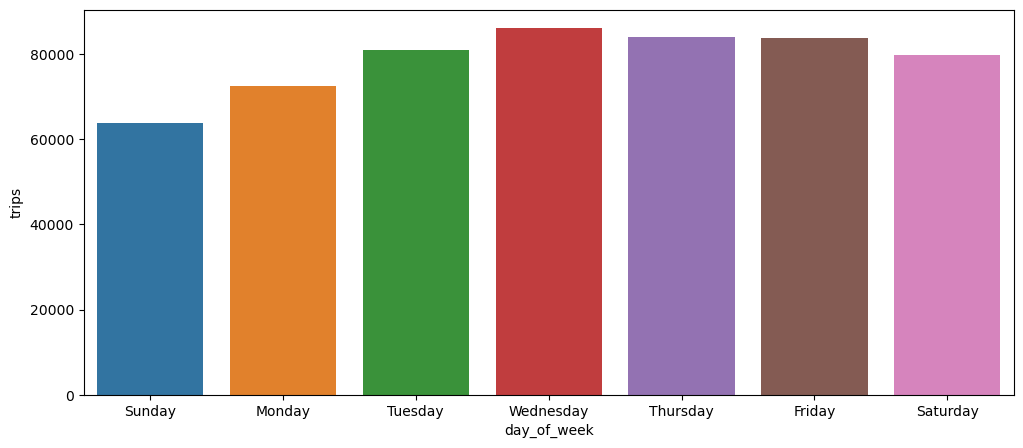

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="trips",
    data=data
)

In [38]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

<function __main__.get_weekday(data)>

In [39]:
query = """
SELECT 
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""


In [40]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [41]:
query = """
SELECT 
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|19011981|12.917660939173045|11.522189365436105|
|                       No Charge|   99259|12.239093784946453| 16.53249925383847|
|                         Dispute|   41360| 13.09763128626692|15.676985848777388|
|                            Cash| 5570959| 12.55897894958479|11.918887182040931|
|                         Unknown|       2|              10.9| 9.758073580374356|
+--------------------------------+--------+------------------+------------------+

